In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches


In [2]:
df = pd.read_csv("workout_fitness_tracker_data.csv")

In [3]:
# Step 1: Extract behavioral features
features = [
    "Workout Duration (mins)",
    "Calories Burned",
    "Steps Taken",
    "Workout Intensity",
    "Mood Before Workout",
    "Mood After Workout"
]
df_selected = df[features]

In [4]:
# Step 2: Preprocess data
numeric_features = ["Workout Duration (mins)", "Calories Burned", "Steps Taken"]
categorical_features = ["Workout Intensity", "Mood Before Workout", "Mood After Workout"]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="first")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [6]:
# Step 3: Apply k-Means clustering (3 groups: Active, Lazy, Inconsistent)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("cluster", kmeans)])
df_selected["Cluster"] = pipeline.fit_predict(df_selected)

C:\Users\Mr\AppData\Local\Temp\ipykernel_2028\1962685414.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected["Cluster"] = pipeline.fit_predict(df_selected)


In [7]:
# Step 4: PCA for dimensionality reduction
X_processed = preprocessor.fit_transform(df_selected.drop(columns=["Cluster"]))
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X_processed)

In [8]:
# Step 5: Silhouette Score for validation
sil_score = silhouette_score(X_processed, df_selected["Cluster"])
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.145


In [10]:
# Step 6: Map clusters to workout styles based on average metrics
cluster_summary = df_selected.groupby("Cluster")[numeric_features].mean()

# Assign cluster labels
cluster_labels = {}
sorted_clusters = cluster_summary.mean(axis=1).sort_values(ascending=False).index.tolist()
cluster_labels[sorted_clusters[0]] = "Active"
cluster_labels[sorted_clusters[1]] = "Inconsistent"
cluster_labels[sorted_clusters[2]] = "Lazy"
df_selected["Workout_Style"] = df_selected["Cluster"].map(cluster_labels)

C:\Users\Mr\AppData\Local\Temp\ipykernel_2028\535825621.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected["Workout_Style"] = df_selected["Cluster"].map(cluster_labels)


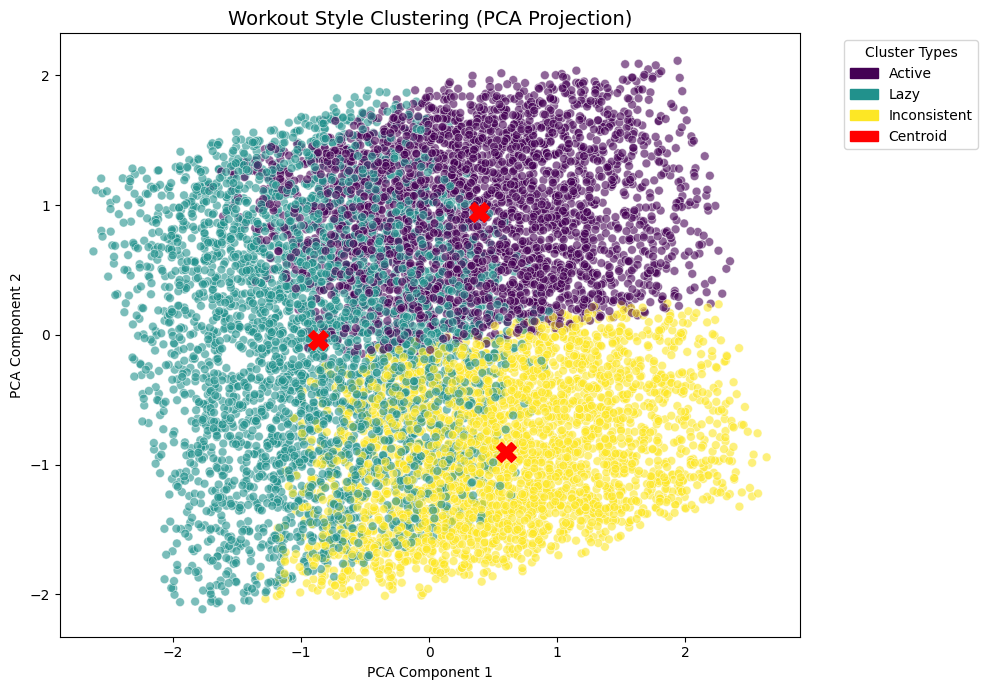

In [18]:
# Step 7: PCA Visualization (legend only, no colorbar)
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=df_selected["Cluster"], cmap="viridis",
    s=40, alpha=0.6, edgecolors='w', linewidth=0.5
)

plt.title("Workout Style Clustering (PCA Projection)", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Cluster labels
cluster_labels = {0: "Active", 1: "Lazy", 2: "Inconsistent"}

# Create legend handles for clusters
handles = [
    mpatches.Patch(color=plt.cm.viridis(i / (len(cluster_labels)-1)), label=label)
    for i, label in cluster_labels.items()
]

# Add centroid marker
handles.append(mpatches.Patch(color='red', label='Centroid'))

# Plot centroids
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],
            c="red", s=200, marker="X")

# Add legend (outside plot)
plt.legend(handles=handles, title="Cluster Types",
           bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [13]:
# Step 8: Merge back into original DataFrame
df_labeled = df.join(df_selected[["Cluster", "Workout_Style"]])
df_labeled.head()

,User ID,Age,Gender,Height (cm),Weight (kg),Workout Type,Workout Duration (mins),Calories Burned,Heart Rate (bpm),Steps Taken,...,Sleep Hours,Water Intake (liters),Daily Calories Intake,Resting Heart Rate (bpm),VO2 Max,Body Fat (%),Mood Before Workout,Mood After Workout,Cluster,Workout_Style
0,1,39,Male,175,99,Cycling,79,384,112,8850,...,8.2,1.9,3195,61,38.4,28.5,Tired,Fatigued,2,Inconsistent
1,2,36,Other,157,112,Cardio,73,612,168,2821,...,8.6,1.9,2541,73,38.4,28.5,Happy,Energized,0,Lazy
2,3,25,Female,180,66,HIIT,27,540,133,18898,...,9.8,1.9,3362,80,38.4,28.5,Happy,Fatigued,1,Active
3,4,56,Male,154,89,Cycling,39,672,118,14102,...,5.8,1.9,2071,65,38.4,28.5,Neutral,Neutral,1,Active
4,5,53,Other,194,59,Strength,56,410,170,16518,...,7.3,1.9,3298,59,38.4,28.5,Stressed,Energized,1,Active


In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

kmeans_pca = KMeans(n_clusters=3, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_pca)

plt.figure(figsize=(8,5))
for cluster in range(3):
    plt.scatter(
        X_pca[clusters_pca == cluster, 0],
        X_pca[clusters_pca == cluster, 1],
        label = f'Cluster {cluster}'
    )
plt.title("K-Means After PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()